In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
import math
import os
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from datetime import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.tsa.stattools as ts

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [3]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
df_berk = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv")

In [4]:
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))

In [5]:
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))

In [6]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips']

In [7]:
# gets list of all fips numbers
def get_fips():
    Y = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
    return set(Y.countyFIPS.values)

def get_date(datestr, formatstr='%Y-%m-%d'):
    return datetime.strptime(datestr, formatstr)

In [179]:
class CumDeathCounter:
    def __init__(self):
        self.df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties.csv")
        self.df = self.df.iloc[np.where(~pd.isna(self.df['fips']))]
        self.df = self.d
        fips = self.df.fips.unique()

        self.cache = {}
        for fip in fips:
            self.cache[fip] = self.get_cum_deaths(fip)
    def get_cum_deaths(self, fips):
        df_county = self.df[self.df.fips == fips]
        X = df_county.date.map(lambda day: (get_date(day) - get_date('2020-01-01')).days).values
        y_deaths = df_county.deaths.values
        return (X, y_deaths)
    def getY(self, fips):
        return self.cache[fips]
class CumCaseCounter:
    def __init__(self):
        self.df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties.csv")
        self.df = self.df.iloc[np.where(~pd.isna(self.df['fips']))]
        self.df['fips'] = self.df['fips'].map(lambda fip : int(fip))
        fips = self.df.fips.unique()

        self.cache = {}
        for fip in fips:
            self.cache[fip] = self.get_cum_cases(fip)
    def get_cum_cases(self, fips):
        df_county = self.df[self.df.fips == fips]
        X = df_county.date.map(lambda day: (get_date(day) - get_date('2020-01-01')).days).values
        y_cases = df_county.cases.values
        return (X, y_cases)
    def getY(self, state):
        return self.cache[state]
class DeltaCounter:
    def __init__(self, counter):
        self.counter = counter
    def getY(self, fips):
        X, y = self.counter.getY(fips)
        y_true = [y[0]]
        for i in range(1, len(y)):
            y_true.append(y[i] - y[i-1])
        return X, y_true
class RatioCounter:
    def __init__(self, counter):
        self.counter = counter
    def getY(self, state, avg_period=5):
        X_raw, y_raw = self.counter.getY(state)
        y = []
        running_sum = 0.0
        running_time = 0
        for i in range(len(X_raw)):
            if y_raw[i] == 0:
                y.append(0)
            elif running_sum == 0:
                y.append(1) # if this is the first case we define the signal as 1
            else:
                avg = running_sum/running_time
                y.append(y_raw[i]/avg)
            if running_time == avg_period:
                running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
            else:
                running_sum = running_sum + y_raw[i]
                running_time = running_time + 1    
            if running_sum == 0:
                running_time = 1
        return (X_raw, np.array(y))

In [65]:
cum_death_counter = CumDeathCounter()
cum_case_counter = CumCaseCounter()
delta_death_counter = DeltaCounter(cum_death_counter)
delta_case_counter = DeltaCounter(cum_case_counter)
delta_death_ratio_counter = RatioCounter(delta_death_counter)
delta_case_ratio_counter = RatiCounter(delta_case_counter)

In [72]:
data_dir = f'{homedir}/data/us/mobility'
# Data contains information about states and counties with states listed before their respective counties
df_mob = pd.read_csv(os.path.join(data_dir, 'DL-us-mobility-daterow.csv'))
counties = df_mob[df_mob['admin_level'] == 2]
counties['fips'] = counties['fips'].map(lambda f: int(f));
def get_mobility(fips):
    data = counties[counties['fips'] == fips]
    t = data['date'].map(lambda d: (get_date(d) - get_date('2020-01-01')).days)
    y = data['m50_index']
    return (t.values, y.values)

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Simple OLS

In [73]:
df = df_jhu[features]

In [115]:
def get_XY(features, delta_y, look_back_y, y_generator):
    df = df_jhu[features]
    df = df[df.fips % 1000 != 0] # remove aggregate states
    df = df[df.State != 'PR']   # peurto rico has some weird data...
    df = df[df.POP_ESTIMATE_2018 > 1000] # restrict to large counties since getting lots of data is difficult

    # fill out missing data
    df.at['02158', 'Area in square miles - Land area'] = 19673
    df.at['02158', 'Density per square mile of land area - Population'] = 0.44
    df.at['46102', 'Area in square miles - Land area'] = 2097
    df.at['46102', 'Density per square mile of land area - Population'] = 6.5

    n, d = df.shape
    col_names = []
    for i in range(5):
        col_name = "y at t = -%d" %i
        col_names.append(col_name)
        df[col_name] = np.zeros(n)
    X = []
    Y = []
    for fips in df.index:
        base = df.loc[fips].values
        try:
            t, ys = y_generator.getY(int(fips))
        except KeyError:
            continue
        if len(ys) == 0:
            X.append(base)
            Y.append(0)
            continue
        for j in range(-1, -len(ys), -int(delta_y/2)):
            base = df.loc[fips].values
            Y.append(ys[j])
            for i in range(look_back_y):
                if j - look_back_y - i >= -len(ys):
                    base[-look_back_y + i] = ys[j - look_back_y - i]
            X.append(base)
    df_new = pd.DataFrame(X, columns = df.columns)
    df_new['target'] = Y
    return df_new

In [268]:
df_new = get_XY(features, 10, 14, delta_death_counter)

(array([1.6342e+04, 1.5600e+02, 4.9000e+01, 1.7000e+01, 1.0000e+01,
        1.3000e+01, 6.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-3. ,  5.8, 14.6, 23.4, 32.2, 41. , 49.8, 58.6, 67.4, 76.2, 85. ]),
 <a list of 10 Patch objects>)

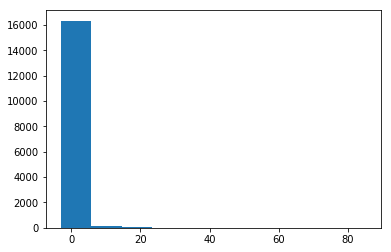

In [269]:
X = df_new.iloc[:,2:-1].values
y = df_new['target'].values
plt.hist(y)

In [270]:
train_num = int(y.shape[0] * 0.66)
X_test = X[train_num:,:]
y_test = y[train_num:]
X_train = X[:train_num,:]
y_train = y[:train_num]
model = sm.OLS(y_train,X_train)
result = model.fit()
print(result.summary())

def Rsquare(pred, actual):   
    ybar = np.sum(actual)/len(actual)          # or sum(y)/len(y)
    ssreg = np.sum((pred-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((actual - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    return ssreg/sstot
print("R squared (out sample) is %f" % (Rsquare(result.predict(X_test), y_test)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     396.0
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        00:12:17   Log-Likelihood:                -26345.
No. Observations:               10956   AIC:                         5.273e+04
Df Residuals:                   10936   BIC:                         5.288e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.338e-06   3.97e-07     13.448      0.0

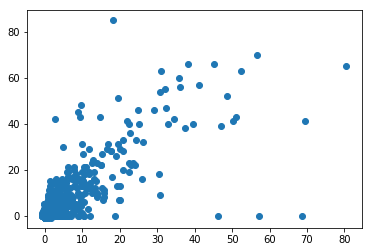

In [265]:
plt.scatter(result.predict(X_train), y_train)

## LightGBM

[1]	valid_0's l2: 1.77883
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 1.65296
[3]	valid_0's l2: 1.547
[4]	valid_0's l2: 1.46095
[5]	valid_0's l2: 1.37345
[6]	valid_0's l2: 1.29918
[7]	valid_0's l2: 1.25126
[8]	valid_0's l2: 1.19903
[9]	valid_0's l2: 1.15558
[10]	valid_0's l2: 1.10853
[11]	valid_0's l2: 1.08326
[12]	valid_0's l2: 1.05558
[13]	valid_0's l2: 1.04349
[14]	valid_0's l2: 1.03201
[15]	valid_0's l2: 1.02503
[16]	valid_0's l2: 1.03945
[17]	valid_0's l2: 1.04447
[18]	valid_0's l2: 1.06869
[19]	valid_0's l2: 1.08302
[20]	valid_0's l2: 1.09034
[21]	valid_0's l2: 1.10876
[22]	valid_0's l2: 1.13747
[23]	valid_0's l2: 1.1778
[24]	valid_0's l2: 1.19223
[25]	valid_0's l2: 1.21813
Early stopping, best iteration is:
[15]	valid_0's l2: 1.02503
R squared (in sample) is 0.178331
R squared (out sample) is 0.526505


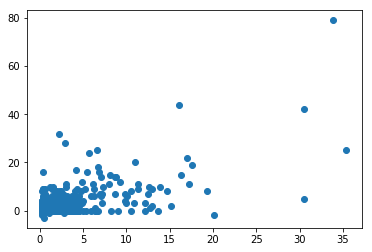

In [148]:
gbm = lgb.LGBMRegressor(num_leaves=50,
                        learning_rate=0.05,
                        n_estimators=2000);
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=10);
pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
print("R squared (in sample) is %f" % Rsquare(pred_train, y_train))
pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print("R squared (out sample) is %f" % Rsquare(pred_test, y_test))
plt.scatter(pred_test, y_test)

## Augmented Dickey Fuller Test for Stationary Time Series

In [150]:
X, y = delta_death_counter.getY(17001)
adfTest = ts.adfuller(y, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
#Add Critical Values
for key,value in adfTest[4].items():
    dfResults['Critical Value (%s)'%key] = value
print('Augmented Dickey-Fuller Test Results:')
print(dfResults)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic            NaN
P-Value                       NaN
# Lags Used              0.000000
# Observations Used     33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
dtype: float64


/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Conclude: time series is stationary

In [151]:
fips_list = get_fips()
stationary = 0
non_stationary = 0
for fips in fips_list:
    X, y = delta_death_ratio_counter.getY(fips)
    if len(y) < 6:
        continue
    adfTest = ts.adfuller(y, maxlag=4)
    if adfTest[1] > 0.05:
            non_stationary += 1
    else:
            stationary += 1

print ("stationary %d, non-stat %d" % (stationary, non_stationary))

KeyError: 0

## ARIMA Model

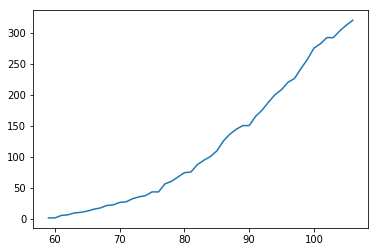

In [178]:
# some counties: King (53033), NYC (36061), Chicago (17031), LA (6037), Wayne, MI (26163), Queens(36059), King (nyc) (36047)
X, y = get_cum_deaths(53033)
plt.plot(X,y)

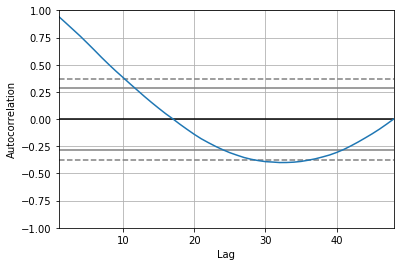

In [179]:
autocorrelation_plot(y)

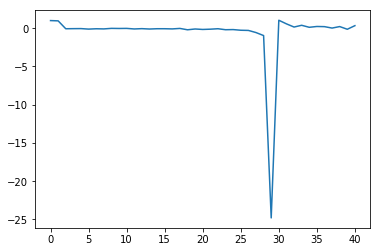

In [180]:
plt.plot(pacf(y))

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   46
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -125.876
Method:                       css-mle   S.D. of innovations              3.563
Date:                Fri, 17 Apr 2020   AIC                            267.753
Time:                        18:19:04   BIC                            282.382
Sample:                             2   HQIC                           273.233
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2213      0.049      4.557      0.000       0.126       0.316
ar.L1.D2.y     0.0198      0.158      0.125      0.901      -0.290       0.329
ar.L2.D2.y     0.3093      0.147      2.100      0.0

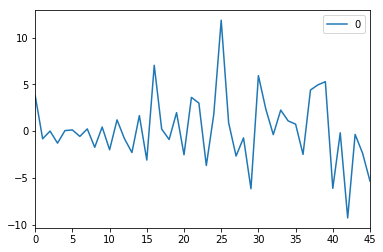

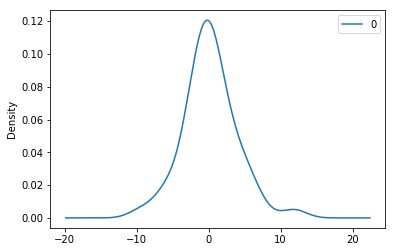

               0
count  46.000000
mean    0.189914
std     3.687064
min    -9.290565
25%    -1.935161
50%     0.021684
75%     1.919813
max    11.847360


In [181]:
model = ARIMA(y, order=(5,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

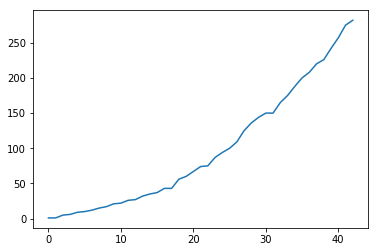

In [182]:
train_sz = int(len(y) * .75)
train_y, test_y = y[:-5], y[-5:]
plt.plot(train_y)

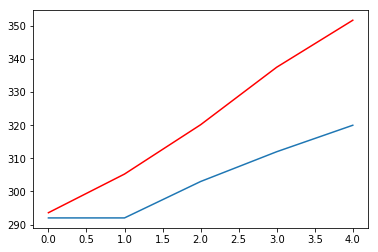

In [185]:
model= ARIMA(train_y, order=(5,2,1))
model_fit = model.fit(disp=0)
pred = model_fit.forecast(5)[0]
plt.plot(test_y)
plt.plot(pred, color='red')
plt.show()

# Doing Shit, But on States

In [205]:
class CumDeathCounterStates:
    def __init__(self):
        self.df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_states.csv")
        states = self.df.state.unique()

        self.cache = {}
        for state in states:
            self.cache[state] = self.get_cum_deaths(state)
    def get_cum_deaths(self, state_name):
        df_state = self.df[self.df.state == state_name]
        X = df_state.date.map(lambda day: (get_date(day) - get_date('2020-01-01')).days).values
        y_deaths = df_state.deaths.values
        return (X, y_deaths)
    def getY(self, state):
        return self.cache[state]
class CumCaseCounterStates:
    def __init__(self):
        self.df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_states.csv")
        states = self.df.state.unique()

        self.cache = {}
        for state in states:
            self.cache[state] = self.get_cum_cases(state)
    def get_cum_cases(self, state_name):
        df_state = self.df[self.df.state == state_name]
        X = df_state.date.map(lambda day: (get_date(day) - get_date('2020-01-01')).days).values
        y_cases = df_state.cases.values
        return (X, y_cases)
    def getY(self, state):
        return self.cache[state]
class DeltaCounterStates:
    def __init__(self, cumDeathCounterStates):
        self.cumDeathCounterStates = cumDeathCounterStates
    def getY(self, state):
        X, y = self.cumDeathCounterStates.getY(state)
        y_true = [y[0]]
        for i in range(1, len(y)):
            y_true.append(y[i] - y[i-1])
        return X, y_true
class RatioCounterStates:
    def __init__(self, counter):
        self.counter = counter
    def getY(self, state, avg_period=5):
        X_raw, y_raw = self.counter.getY(state)
        y = []
        running_sum = 0.0
        running_time = 0
        for i in range(len(X_raw)):
            if y_raw[i] == 0:
                y.append(0)
            elif running_sum == 0:
                y.append(1) # if this is the first case we define the signal as 1
            else:
                avg = running_sum/running_time
                y.append(y_raw[i]/avg)
            if running_time == avg_period:
                running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
            else:
                running_sum = running_sum + y_raw[i]
                running_time = running_time + 1    
            if running_sum == 0:
                running_time = 1
        
        offset = 0
        while y[offset] == 0:
            offset += 1
            if offset == len(y):
                return (X_raw, np.array(y))
        return X_raw[offset:], y[offset:]

In [206]:
cumDeathCounterStates = CumDeathCounterStates()
cumCaseCounterStates = CumCaseCounterStates()
deltaDeathCounterStates = DeltaCounterStates(cumDeathCounterStates)
deltaCaseCounterStates = DeltaCounterStates(cumCaseCounterStates)
ratioCounterStates = RatioCounterStates(deltaDeathCounterStates)

## Are State Daily Death Ratios Stationary (ADF, Again)

In [213]:
states_list = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_states.csv").state.unique()
stationary = 0
non_stationary = 0
for state in states_list:
    X, y = ratioCounterStates.getY(state,1)
    if len(y) < 6:
        continue
    adfTest = ts.adfuller(y, maxlag=4)
    if adfTest[1] > 0.05:
            non_stationary += 1
            print(state)
    else:
            stationary += 1

print ("stationary %d, non-stat %d" % (stationary, non_stationary))

Florida
Rhode Island
Maryland
Nevada
Minnesota
South Carolina
Wyoming
Virgin Islands
West Virginia
stationary 47, non-stat 9


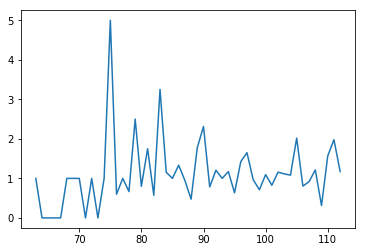

In [241]:
X,y = ratioCounterStates.getY("California",1)
plt.plot(X,y)

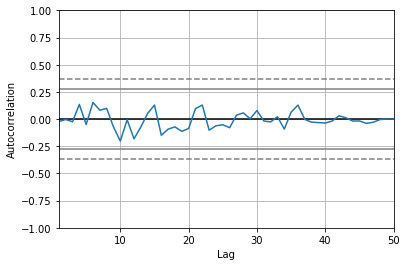

In [242]:
autocorrelation_plot(y)

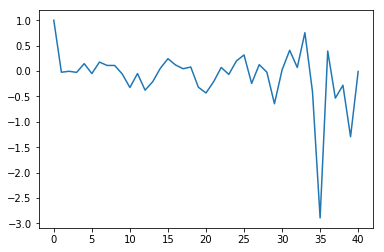

In [243]:
plt.plot(pacf(y))

/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/home/sean/anaconda3/lib/python3.7/site-packa

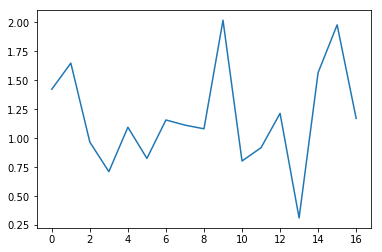

In [254]:
train_sz = int(.66*len(y))
y_train = y[:train_sz]
y_test = y[train_sz:]

model= ARIMA(y_train, order=(7,0,3))
model_fit = model.fit(disp=1)
pred = model_fit.forecast(len(y) - train_sz)[0]
plt.plot(y_test)
plt.plot(pred, color='red')
plt.show()

In [253]:
df = df_jhu[features]
df = df[df.fips % 1000 == 0] # remove aggregate states
df.head()

,State,Area_Name,POP_ESTIMATE_2018,Area in square miles - Land area,Density per square mile of land area - Population,Total_Male,Total_Female,Total_age0to17,Total_age18to64,Total_age65plus,Active Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Non-profit hospital beds per 1000 people (2019),Employed_2018,Unemployment_rate_2018,Total hospital beds per 1000 people (2019),Total nurse practitioners (2019),Total Hospitals (2019),fips
FIPS,,,,,,,,,,,,,,,,,,,
01000,AL,Alabama,4887871,50645.33,94.4,NaN,NaN,NaN,NaN,NaN,217.1,7.6,0.8,2112347.0,3.9,3.1,2537.0,101.0,1000
02000,AK,Alaska,737438,570640.95,1.2,NaN,NaN,NaN,NaN,NaN,276.9,9.6,1.5,333375.0,6.6,2.2,480.0,21.0,2000
04000,AZ,Arizona,7171646,113594.08,56.3,NaN,NaN,NaN,NaN,NaN,242.0,6.9,1.3,3273550.0,4.8,1.9,3403.0,83.0,4000
05000,AR,Arkansas,3013825,52035.48,56.0,NaN,NaN,NaN,NaN,NaN,207.6,7.0,2.2,1301459.0,3.7,3.2,1305.0,88.0,5000
06000,CA,California,39557045,155779.22,239.1,NaN,NaN,NaN,NaN,NaN,279.6,7.2,1.2,18582802.0,4.2,1.8,15414.0,359.0,6000
